In [ ]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

## 00. Purpose 😇

The purpose of this notebook is to show you how you can create a simple, state-of-the-art time series classification model using the great **fastai-v1** library in 4 steps:
1. Import libraries
2. Prepare data
3. Build learner
4. Train model

Throughout the notebook you will see this ✳️. It means there's some value you need to select.

## 01. Import libraries 📚

There are some dependencies you need to have installed to be able to run this repo. If you don't have these packages you will need to install them: 
- pip install Cython
- pip install tslearn
- pip install PyWavelets
- pip install pyts
- pip install fire
- pip install nvidia-ml-py3

In [38]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
import fastai, os
from fastai_timeseries import *
from torchtimeseries.models import *
path = Path(os.getcwd())
print(path)
print('fastai :', fastai.__version__)
print('torch  :', torch.__version__)
print('device :', device)

/home/oguizadl/timeseriesAI
fastai : 1.0.57
torch  : 1.2.0
device : cpu


## 02. Prepare data 🔢

### Download data ⬇️

In this notebook, we'll use one of the most widely used time series classification databases: UEA & UCR Time Series Classification Repository. As of Sep 2019 it contains 128 univariate datasets and 30 multivariate datasets.


In [16]:
#pprint.pprint(get_UCR_univariate_list())

In [14]:
#pprint.pprint(get_UCR_multivariate_list())

In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

In [17]:
# dataset id
dsid = 'ChlorineConcentration'   # ✳️

In [18]:
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)

Dataset: ChlorineConcentration
Successfully extracted dataset
X_train: (467, 1, 166)
y_train: (467,)
X_valid: (3840, 1, 166)
y_valid: (3840,)


☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Features
3. Sequence length (aka time steps)

All UEA & UCR Time Series Classification data have already been split between train and valid. When you use your own data, you'll have to split it yourself. We'll see examples of this in future notebooks.

### Prepare databunch 💿

You always need to define the bs at the time of creating the databunch, the object that contains all data required.

It's also best practice to scale the data using the train stats. There are several options available: 

1. standardization or normalization.

2. calculate them based on all samples, per channel or per sample. 

3. scale range (for normalization only).

The most common practice is to standardize data per channel.

In [19]:
bs = 64                            # ✳️
seed = 1234                        # ✳️
scale_type = 'standardize'         # ✳️ 'standardize', 'normalize'
scale_subtype = 'per_channel'      # ✳️ 'all_samples', 'per_channel', 'per_sample'
scale_range = (-1, 1)              # ✳️ for normalization only: usually left to (-1, 1)

Now, the last step in data preparation is to prepare a databunch.
Time series data may come as numpy arrays, pandas dataframes, etc.
The 2 most common ways to load data into a databunch will be from a numpy array/ torch tensors or a pandas dataframe. Let's see how we'd work in either case. 

#### From 3D numpy arrays/ torch tensors

1) You need to first create ItemLists from TimeSeriesList (custom type of ItemList built for Time Series)

2) You need to label the ItemLists. You'll find a lot of information [here](https://docs.fast.ai/data_block.html)

3) You enter the train bs and val_bs and crate the databunch object. 

4) You add features and seq_len.

In [20]:
db = (ItemLists('.', TimeSeriesList(X_train), TimeSeriesList(X_valid))
      .label_from_lists(y_train, y_valid)
      .databunch(bs=min(bs, len(X_train)), val_bs=min(len(X_valid), bs * 2), num_workers=cpus, device=device)
      .scale(scale_type=scale_type, scale_subtype=scale_subtype, scale_range=scale_range)
     )
db

TSDataBunch;

Train: LabelList (467 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166)
y: CategoryList
1,3,1,3,2
Path: .;

Valid: LabelList (3840 items)
x: TimeSeriesList
TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166),TimeSeries(ch=1, seq_len=166)
y: CategoryList
2,2,1,3,2
Path: .;

Test: None

#### From pandas dataframe

In [ ]:
# dsid = 'NATOPS' 
# X_train, y_train, X_valid, y_valid = get_UCR_data(dsid)
# for ch in range(X_train.shape[-2]):
#     data_ch = np.concatenate((np.full((len(np.concatenate((X_train, X_valid))), 1), ch),
#                               np.concatenate((X_train, X_valid))[:, ch], 
#                               np.concatenate((y_train, y_valid))[:, None]), axis=-1)
#     if ch == 0: data = data_ch
#     else: data = np.concatenate((data, data_ch))
# df = pd.DataFrame(data, columns=['feat'] + list(np.arange(X_train.shape[-1]).astype('str')) + ['target'])
# df.to_csv(path/f'data/UCR/{dsid}/{dsid}.csv', index=False)
# pd.read_csv(path/f'data/UCR/{dsid}/{dsid}.csv')
# print(df.shape)
# df.head()

In [ ]:
dsid = 'NATOPS'   # ✳️
df = pd.read_csv(path/f'data/UCR/{dsid}/{dsid}.csv')
print(df.shape)
display(df.head())

🔎 To create the TimeSeriesList, you need to select the columns that contain the time series only, neither the target, not the feature (for multivariate TS).

🔎 You should use **label_cls=CategoryList** when labels are floats but it is a classification problem. Otherwise, the fastai library would take it as a regression problem.

1) You need to first TimeSeriesList (custom type of ItemList built for Time Series) from the dataframe. As cols you should only enter the data from the time series (X values, not y).

2) Then you split the TimeSeriesList into 2 lists (traina and valid). There are multiple ways to do that. More info [here](https://docs.fast.ai/data_block.html)

3) You need to label the ItemLists. You'll find a lot of information [here](https://docs.fast.ai/data_block.html)

4) You enter the train bs and val_bs and crate the databunch object. 

5) You add features and seq_len.

In [ ]:
db = (TimeSeriesList.from_df(df, '.', cols=df.columns.values[:-1], feat='feat')
      .split_by_rand_pct(valid_pct=0.2, seed=seed)
      .label_from_df(cols='target', label_cls=CategoryList)
      .databunch(bs=bs,  val_bs=bs * 2,  num_workers=cpus,  device=device)
      .scale(scale_type=scale_type, scale_subtype=scale_subtype, scale_range=scale_range)
     )
db

### Visualize data

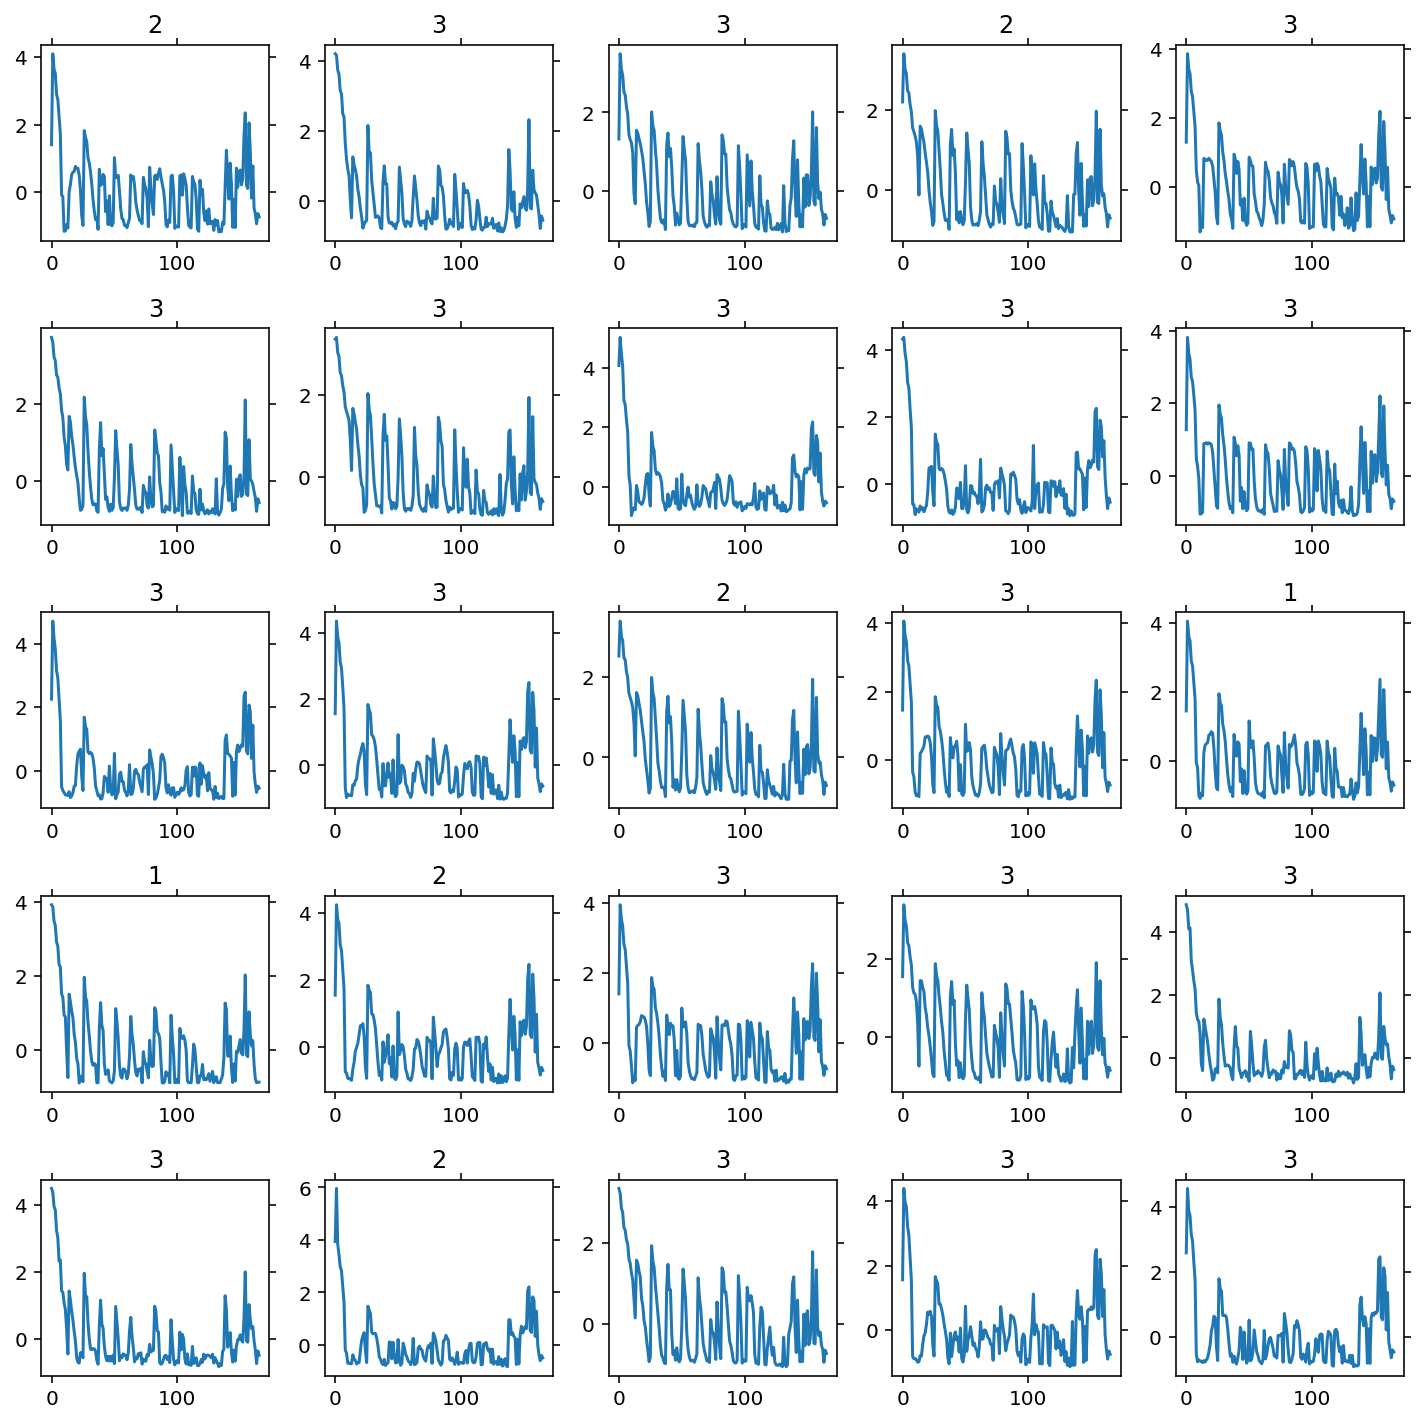

In [21]:
db.show_batch()

## 03. Build learner 🏗

In [22]:
# Select one arch from these state-of-the-art time series/ 1D models:
# ResCNN, FCN, InceptionTime, ResNet
arch = InceptionTime                     # ✳️   
arch_kwargs = dict()                     # ✳️ 
opt_func=Ranger                          # ✳️ a state-of-the-art optimizer
loss_func = LabelSmoothingCrossEntropy() # ✳️

In [23]:
model = arch(db.features, db.c, **arch_kwargs).to(device)
learn = Learner(db, model, opt_func=opt_func, loss_func=loss_func)
learn.save('stage_0')
print(learn.model)
print(learn.summary())

InceptionTime(
  (block): InceptionBlock(
    (inc_mods): ModuleList(
      (0): Inception(
        (conv_layers): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        )
        (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): Inception(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (conv_layers): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,))
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    

## 04. Train model 🚵🏼‍

### LR find 🔎

In [ ]:
learn.load('stage_0')
learn.lr_find()
learn.recorder.plot()

### Train 🏃🏽‍♀️

In [24]:
epochs = 100         # ✳️ 
max_lr = 1e-2        # ✳️ 
warmup = False       # ✳️
pct_start = .7       # ✳️
metrics = [accuracy] # ✳️
wd = 1e-2

In [25]:
learn.metrics = metrics
learn.load('stage_0')
learn.fit_one_cycle(epochs, max_lr=max_lr, pct_start=pct_start, moms=(.95, .85) if warmup else (.95, .95),
                    div_factor=25.0 if warmup else 1., wd=wd)
learn.save('stage_1')
learn.recorder.plot_lr()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,1.032974,1.052404,0.532552,00:22


KeyboardInterrupt: 

### Results

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return

In [27]:
probas, y_true = learn.get_preds(ds_type=DatasetType.Valid)
y_pred = np.argmax(probas, axis=1)

In [ ]:
unique_labels(y_true, y_pred)

Confusion matrix, without normalization
[[   0    0  886]
 [   0    0  909]
 [   0    0 2045]]


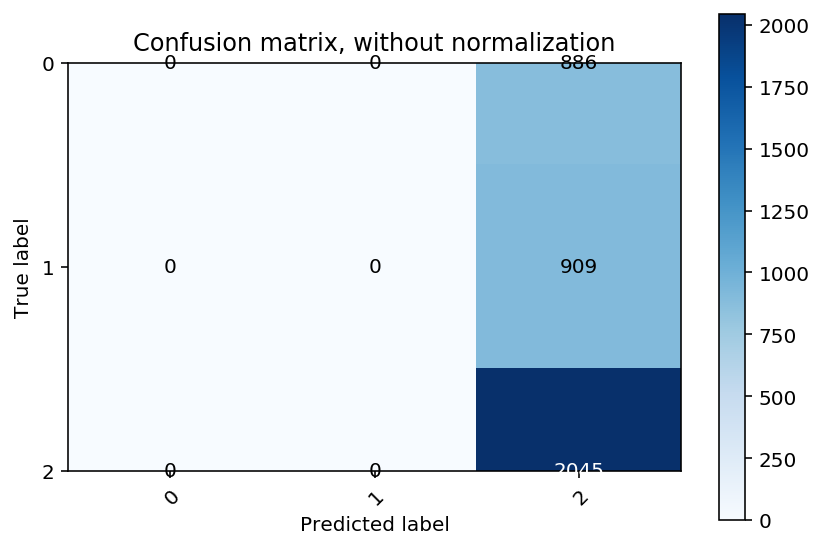

In [40]:
plot_confusion_matrix(y_true, y_pred, learn.data.classes)

## 05. Training loop

In [ ]:
from torchtimeseries.models import *
ResNetLWE = partial(LWEnsembler, cls='ResNet')
setattr(ResNetLWE, '__name__', 'ResNetLWE')
InceptionTimeLWE = partial(LWEnsembler, cls='InceptionTime')
setattr(InceptionTimeLWE, '__name__', 'InceptionTimeLWE')
ResNetE = partial(LWEnsembler, cls='ResNet', trainable=False)
setattr(ResNetE, '__name__', 'ResNetE')
InceptionTimeE = partial(LWEnsembler, cls='InceptionTime', trainable=False)
setattr(InceptionTimeE, '__name__', 'InceptionTimeE')

archs =  [InceptionTimeLWE] * 10# + [InceptionTimeE] * 10 # ✳️   
opt_func=partial(Ranger, alpha=0.5, k=5) # ✳️ 
loss_func = LabelSmoothingCrossEntropy() # ✳️ 

epochs = 100       # ✳️ 
max_lr = 1e-2        # ✳️ 
warmup = False       # ✳️
pct_start=0.
metrics = [accuracy] # ✳️
wd = 1e-2

In [ ]:
archs_names, acc_, acces_, acc5_, n_params_,  = [], [], [], [], []
for i, arch in enumerate(archs):
    archs_names.append(arch.__name__)
    print(i, arch.__name__)
    seq_mods = [MLSTM_FCN, LSTM_FCN, GRU_FCN, ResNetLWE, InceptionTimeLWE, 
                ResNetE, InceptionTimeE]
    model_args = [db.features, db.c] if arch not in seq_mods else [db.features,db.seq_len,db.c]
    model = arch(*model_args).to(device)
    learn = Learner(db, model, opt_func=opt_func, loss_func=loss_func)
    learn.metrics = metrics
    learn.fit_one_cycle(epochs,
                        max_lr=max_lr,
                        pct_start=pct_start,
                        moms=(.95, .85) if warmup else (.95, .95),
                        div_factor=25.0 if warmup else 1.,
                       wd=wd)
    early_stop = math.ceil(np.argmin(learn.recorder.losses) / len(learn.data.train_dl))
    acc_.append('{:.5}'.format(learn.recorder.metrics[-1][0].item()))
    acces_.append('{:.5}'.format(learn.recorder.metrics[early_stop - 1][0].item()))
    acc5_.append('{:.5}'.format(np.mean(np.max(learn.recorder.metrics))))
    n_params_.append(count_params(learn))
    clear_output()
    df = (pd.DataFrame(np.stack((archs_names, acc_, acces_, acc5_, n_params_)).T,
                       columns=['arch', 'accuracy', 'accuracy train loss', 'max_accuracy','n_params'])
          .sort_values('accuracy train loss', ascending=False).reset_index(drop=True))
    display(df)

In [ ]:
from torchtimeseries.models import *
ResNetLWE = partial(LWEnsembler, cls='ResNet')
setattr(ResNetLWE, '__name__', 'ResNetLWE')
InceptionTimeLWE = partial(LWEnsembler, cls='InceptionTime')
setattr(InceptionTimeLWE, '__name__', 'InceptionTimeLWE')
ResNetE = partial(LWEnsembler, cls='ResNet', trainable=False)
setattr(ResNetE, '__name__', 'ResNetE')
InceptionTimeE = partial(LWEnsembler, cls='InceptionTime', trainable=False)
setattr(InceptionTimeE, '__name__', 'InceptionTimeE')

archs =  [InceptionTimeLWE] * 10# + [InceptionTimeE] * 10 # ✳️   
opt_func=partial(Ranger, alpha=0.5, k=5) # ✳️ 
loss_func = nn.CrossEntropyLoss() # ✳️ 

epochs = 100       # ✳️ 
max_lr = 1e-2        # ✳️ 
warmup = False       # ✳️
pct_start=0.7
metrics = [accuracy] # ✳️
wd = 1e-2

In [ ]:
archs_names, acc_, acces_, acc5_, n_params_,  = [], [], [], [], []
for i, arch in enumerate(archs):
    archs_names.append(arch.__name__)
    print(i, arch.__name__)
    seq_mods = [MLSTM_FCN, LSTM_FCN, GRU_FCN, ResNetLWE, InceptionTimeLWE, 
                ResNetE, InceptionTimeE]
    model_args = [db.features, db.c] if arch not in seq_mods else [db.features,db.seq_len,db.c]
    model = arch(*model_args).to(device)
    learn = Learner(db, model, opt_func=opt_func, loss_func=loss_func)
    learn.metrics = metrics
    learn.fit_one_cycle(epochs,
                        max_lr=max_lr,
                        pct_start=pct_start,
                        moms=(.95, .85) if warmup else (.95, .95),
                        div_factor=25.0 if warmup else 1.,
                       wd=wd)
    early_stop = math.ceil(np.argmin(learn.recorder.losses) / len(learn.data.train_dl))
    acc_.append('{:.5}'.format(learn.recorder.metrics[-1][0].item()))
    acces_.append('{:.5}'.format(learn.recorder.metrics[early_stop - 1][0].item()))
    acc5_.append('{:.5}'.format(np.mean(np.max(learn.recorder.metrics))))
    n_params_.append(count_params(learn))
    clear_output()
    df = (pd.DataFrame(np.stack((archs_names, acc_, acces_, acc5_, n_params_)).T,
                       columns=['arch', 'accuracy', 'accuracy train loss', 'max_accuracy','n_params'])
          .sort_values('accuracy train loss', ascending=False).reset_index(drop=True))
    display(df)

In [ ]:
class LWEnsembler(nn.Module):
    def __init__(self, c_in, seq_len, c_out, iters=5, trainable=True, 
                 cls='ResNet', one_mult=True, **kwargs):
        super().__init__()
        cls = cls * iters if isinstance(cls, list) else [cls] * iters
        self.iters = len(cls)
        clss, w = [], []
        for i in range(self.iters):
            clss.append(get_cls(cls[i], c_in, seq_len, c_out, **kwargs))
            w.append(Mult(1. if one_mult or i == 0 else 0., trainable=trainable))
        self.clss = nn.ModuleList(clss)
        self.w = nn.ModuleList(w)

    def forward(self, x):
        for i in range(self.iters):
            pred_i = self.clss[i](x)
            if i == 0: pred = self.w[i](pred_i)
            else: pred += self.w[i](pred_i)
        return pred

In [ ]:
class MultiLossLWEnsembler(nn.Module):
    def __init__(self, c_in, seq_len, c_out, iters=5, trainable=True, 
                 cls='ResNet', one_mult=True, λ=1.0, cum=True, **kwargs):
        super().__init__()
        self.λ, self.cum = λ, cum
        cls = cls * iters if isinstance(cls, list) else [cls] * iters
        self.iters = len(cls)
        clss, w = [], []
        for i in range(self.iters):
            clss.append(get_cls(cls[i], c_in, seq_len, c_out, **kwargs))
            w.append(Mult(1. if one_mult or i == 0 else 0., trainable=trainable))
        self.clss = nn.ModuleList(clss)
        self.w = nn.ModuleList(w)

    def forward(self, x):
        pred = []
        for i in range(self.iters):
            pred_i = self.w[i](self.clss[i](x))
            if i == 0: pred_sum = pred_i
            else: pred_sum += pred_i
            if self.cum: pred.append(pred_sum)
            else: pred.append(pred_i)
        if not self.cum: pred.append(pred_sum)
        pred.append(self.λ)
        return pred

In [ ]:
xb, yb = learn.data.one_batch()

In [ ]:
output = MultiLossLWEnsembler(db.features,db.seq_len,db.c).to(device)(xb.to(device))
isinstance(output, list), len(output)

In [ ]:
class MultiLoss(nn.Module):
    def __init__(self, crit=nn.CrossEntropyLoss()):
        super().__init__()
        self.crit = crit

    def forward(self, output, target):
        if not isinstance(output, list): return crit(output, target)
        else:
            λ = output[-1]
            loss = λ * self.crit(output[-2], target)
            levels = len(output) - 2
            joint_loss = [self.crit(output[k], target) for k in range(0, levels)]
            loss += (1 - λ) * torch.mean(torch.stack(joint_loss))
            return loss

In [ ]:
def multimetric(metric, input, targs):
    if isinstance(input, list): return metric(input[-2], targs)
    else: return metric(input, targs)

In [ ]:
MultiLoss()(output, yb.to(device))

In [ ]:
multimetric(accuracy, output, yb.to(device))

In [ ]:
from torchtimeseries.models import *
InceptionTimeLWE1 = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=1.)
setattr(InceptionTimeLWE1, '__name__', 'InceptionTimeLWE1')
InceptionTimeLWE0 = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=0.)
setattr(InceptionTimeLWE0, '__name__', 'InceptionTimeLWE0')
InceptionTimeLWE05 = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=0.5)
setattr(InceptionTimeLWE05, '__name__', 'InceptionTimeLWE05')
InceptionTimeLWE08 = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=0.8)
setattr(InceptionTimeLWE08, '__name__', 'InceptionTimeLWE08')

InceptionTimeE1 = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=1.)
setattr(InceptionTimeE1, '__name__', 'InceptionTimeE1')
InceptionTimeE0 = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=0.)
setattr(InceptionTimeE0, '__name__', 'InceptionTimeE0')
InceptionTimeE05 = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=0.5)
setattr(InceptionTimeE05, '__name__', 'InceptionTimeE05')
InceptionTimeE08 = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=0.8)
setattr(InceptionTimeE08, '__name__', 'InceptionTimeE08')

InceptionTimeLWE08single = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=0.8, cum=False)
setattr(InceptionTimeLWE08single, '__name__', 'InceptionTimeLWE08single')
InceptionTimeE08single = partial(MultiLossLWEnsembler, cls='InceptionTime', λ=0.8, cum=False)
setattr(InceptionTimeE08single, '__name__', 'InceptionTimeE08single')

archs =  [InceptionTimeLWE08single, InceptionTimeE08single, InceptionTimeLWE08, InceptionTimeE08, ] * 10 # ✳️   
opt_func=partial(Ranger, alpha=0.5, k=5) # ✳️ 
loss_func = MultiLoss(LabelSmoothingCrossEntropy()) # ✳️ 

epochs = 100         # ✳️ 
max_lr = 1e-2        # ✳️ 
warmup = False       # ✳️
pct_start=0.7        # ✳️
metrics = [partial(multimetric, accuracy)] # ✳️
metrics[0].func.__name__ = metrics[0].args[0].__name__
wd = 1e-2

In [ ]:
archs_names, acc_, acces_, acc5_, n_params_,  = [], [], [], [], []
for i, arch in enumerate(archs):
    archs_names.append(arch.__name__)
    print(i, arch.__name__)
    seq_mods = [MLSTM_FCN, LSTM_FCN, GRU_FCN, ResNetLWE, InceptionTimeLWE, 
                ResNetE, InceptionTimeE, InceptionTimeLWE0, InceptionTimeLWE05, 
                InceptionTimeLWE08, InceptionTimeLWE1, InceptionTimeE0, InceptionTimeE05, 
                InceptionTimeE08, InceptionTimeE1, InceptionTimeLWE08single, InceptionTimeE08single]
    model_args = [db.features, db.c] if arch not in seq_mods else [db.features,db.seq_len,db.c]
    model = arch(*model_args).to(device)
    learn = Learner(db, model, opt_func=opt_func, loss_func=loss_func)
    learn.metrics = metrics
    learn.fit_one_cycle(epochs,
                        max_lr=max_lr,
                        pct_start=pct_start,
                        moms=(.95, .85) if warmup else (.95, .95),
                        div_factor=25.0 if warmup else 1.,
                       wd=wd)
    early_stop = math.ceil(np.argmin(learn.recorder.losses) / len(learn.data.train_dl))
    acc_.append('{:.5}'.format(learn.recorder.metrics[-1][0].item()))
    acces_.append('{:.5}'.format(learn.recorder.metrics[early_stop - 1][0].item()))
    acc5_.append('{:.5}'.format(np.mean(np.max(learn.recorder.metrics))))
    n_params_.append(count_params(learn))
    clear_output()
    df = (pd.DataFrame(np.stack((archs_names, acc_, acces_, acc5_, n_params_)).T,
                       columns=['arch', 'accuracy', 'accuracy train loss', 'max_accuracy','n_params'])
          .sort_values('accuracy train loss', ascending=False).reset_index(drop=True))
    display(df)